In [26]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from bidi import algorithm as bidi_algorithm
import warnings
from bidi.algorithm import get_display


# התעלמות מכל ההתראות
warnings.filterwarnings("ignore")


In [2]:
panel_05_df = pd.read_csv("inputdata/Panel_05.csv")
columns_to_drop = ['YEAR','PRACTICE_CODE','POSTCODE']    
df_after_drop = panel_05_df.drop(columns=columns_to_drop)

### פונקציה - נתונים סטטיסיטים וחריגים

In [4]:
import pandas as pd

def make_stat_and_detect_outliers(df, threshold):
    # הגדרת רשימה ריקה לאחסון התוצאות
    combined_info = []
    
    # לולאה על כל עמודה ב-DataFrame
    for column in df.columns:
        # חישוב מספר הערכים החסרים
        missing_values = df[column].isnull().sum()
        
        # חישוב סטטיסטיקות בסיסיות
        max_value = df[column].max()
        min_value = df[column].min()
        mean_value = df[column].mean()
        median_value = df[column].median()
        q1_value = df[column].quantile(0.25)
        q3_value = df[column].quantile(0.75)
        count_zeros = (df[column] == 0).sum()
        
        # חישוב IQR
        IQR = q3_value - q1_value
        lower_bound_iqr = q1_value - threshold * IQR
        upper_bound_iqr = q3_value + threshold * IQR
        num_outliers_iqr = ((df[column] < lower_bound_iqr) | (df[column] > upper_bound_iqr)).sum()
        percent_outliers_iqr = num_outliers_iqr / len(df) * 100
        
        # חישוב סטיית תקן
        stdev = df[column].std()
        lower_bound_stdev = mean_value - threshold * stdev
        upper_bound_stdev = mean_value + threshold * stdev
        num_outliers_stdev = ((df[column] < lower_bound_stdev) | (df[column] > upper_bound_stdev)).sum()
        percent_outliers_stdev = num_outliers_stdev / len(df) * 100
        
        # הוספת התוצאות לרשימה
        combined_info.append({
            'Column Name': column,
            'Max': max_value,
            'Min': min_value,
            'Mean': mean_value,
            'Median': median_value,
            'Q1': q1_value,
            'Q3': q3_value,
            'Count of Zeros': count_zeros,
            'NULL Values': missing_values,
            '|': '|',
            'Lower Bound IQR': lower_bound_iqr,
            'Upper Bound IQR': upper_bound_iqr,
            'Number of Outliers IQR': num_outliers_iqr,
            'Percent of Outliers IQR': percent_outliers_iqr,
            'Lower Bound STDEV': lower_bound_stdev,
            'Upper Bound STDEV': upper_bound_stdev,
            'Number of Outliers STDEV': num_outliers_stdev,
            'Percent of Outliers STDEV': percent_outliers_stdev
        })
    
    # יצירת DataFrame חדש עבור התוצאות המשולבות
    combined_df = pd.DataFrame(combined_info)
    
    return combined_df


In [5]:
threshold = 1.5
outliers_df = make_stat_and_detect_outliers(df_after_drop, threshold)

In [6]:
# מיון לפי אחוז החריגים לפי IQR בסדר יורד
outliers_sorted_iqr = outliers_df.sort_values(by='Percent of Outliers IQR', ascending=False)
# מיון לפי אחוז החריגים לפי STDEV בסדר יורד
outliers_sorted_stdev = outliers_df.sort_values(by='Percent of Outliers STDEV', ascending=False)
# הצגת התוצאה הממוינת
#outliers_sorted_iqr


#  בדיקה עם ערך ריק במקום אפס

תבונה : החלפת האפסים בתא ריק לא משנה על אחוז החריגים באופן משמעותי

In [ ]:
#מי הערך עם הכי הרבה אפסים
outliers_sorted_by_zero_df = outliers_df.sort_values(by='Count of Zeros', ascending=False)
print(outliers_sorted_by_zero_df.iloc[0, 0])

In [ ]:
#החלפה אפס בערך ריק
df_after_drop_replaced = df_after_drop.replace(0, np.nan)

In [ ]:
threshold = 1.5
outliers_after_replaced_df = make_stat_and_detect_outliers(df_after_drop_replaced, threshold)
outliers_after_replaced_iqr_df = outliers_after_replaced_df.sort_values(by='Percent of Outliers IQR', ascending=False)
# מיון לפי אחוז החריגים לפי STDEV בסדר יורד
outliers_after_replaced_stdev_df = outliers_after_replaced_df.sort_values(by='Percent of Outliers STDEV', ascending=False)
# הצגת התוצאה הממוינת


In [ ]:
row_before = outliers_df.loc[outliers_df['Column Name'] == outliers_sorted_by_zero_df.iloc[0, 0]].copy()
row_after = outliers_after_replaced_df.loc[outliers_df['Column Name'] == outliers_sorted_by_zero_df.iloc[0, 0]].copy()

# הוספת עמודה "סטטוס" לציון אם זה לפני או אחרי ההחלפה
row_before.loc[:, 'Status'] = 'Before'
row_after.loc[:, 'Status'] = 'After'

# איחוד השורות לקובץ אחד
rows_combined = pd.concat([row_before, row_after])
rows_combined

# יצירה של גרפים

### boxplots

In [128]:
def plot_boxplots(df, method, threshold, num_plots=3, figsize=(15, 5), color_palette='Set2'):
    outliers_df = make_stat_and_detect_outliers(df, threshold)
    
    # מיון לפי אחוז החריגים הגבוה ביותר לפי השיטה הנבחרת
    if method == 'IQR':
        outliers_sorted = outliers_df.sort_values(by='Percent of Outliers IQR', ascending=False)
    elif method == 'stdev':
        outliers_sorted = outliers_df.sort_values(by='Percent of Outliers STDEV', ascending=False)
    else:
        raise ValueError("Unsupported method. Choose 'IQR' or 'stdev'.")
    
    # בחירת העמודות עם האחוזים הגבוהים ביותר
    top_columns = outliers_sorted.head(num_plots)['Column Name']
    
    # יצירת גרפים של בוקס פלוט
    fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=figsize)
    
    # בודק אם יש צורך להגדיר פלטת צבעים אחרת
    if isinstance(color_palette, str):
        color_palette = sns.color_palette(color_palette)
    
    for i, column in enumerate(top_columns):
        sns.boxplot(ax=axes[i], data=df[column], color=color_palette[i])
        
        # הוספת הערות לגרף עם גבולות, ממוצע וחציון
        upper_bound_iqr = outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Upper Bound IQR'].values[0]
        lower_bound_iqr = outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Lower Bound IQR'].values[0]
        mean_value = outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Mean'].values[0]
        
        axes[i].axhline(upper_bound_iqr, linestyle='--', color='red', label=f'Upper Bound IQR: {upper_bound_iqr:.2f}')
        axes[i].axhline(lower_bound_iqr, linestyle='--', color='blue', label=f'Lower Bound IQR: {lower_bound_iqr:.2f}')
        axes[i].axhline(mean_value, linestyle='-', color='green', label=f'Mean: {mean_value:.2f}')
        
        axes[i].set_title(f'Boxplot of {column}')
        axes[i].set_ylabel(column)
        axes[i].legend(loc='center right', prop={'size': 8}, title='Values:')
    
    plt.tight_layout()
    plt.show()

In [ ]:
#df_after_drop = pd.DataFrame({
    'A': [0, 2, 3, 4, -10, 6, 7, 18, 9, 19],
    'B': [10, 20, 30, 40, 50, 60, 70, 1000, 90, 100],
    'C': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
})

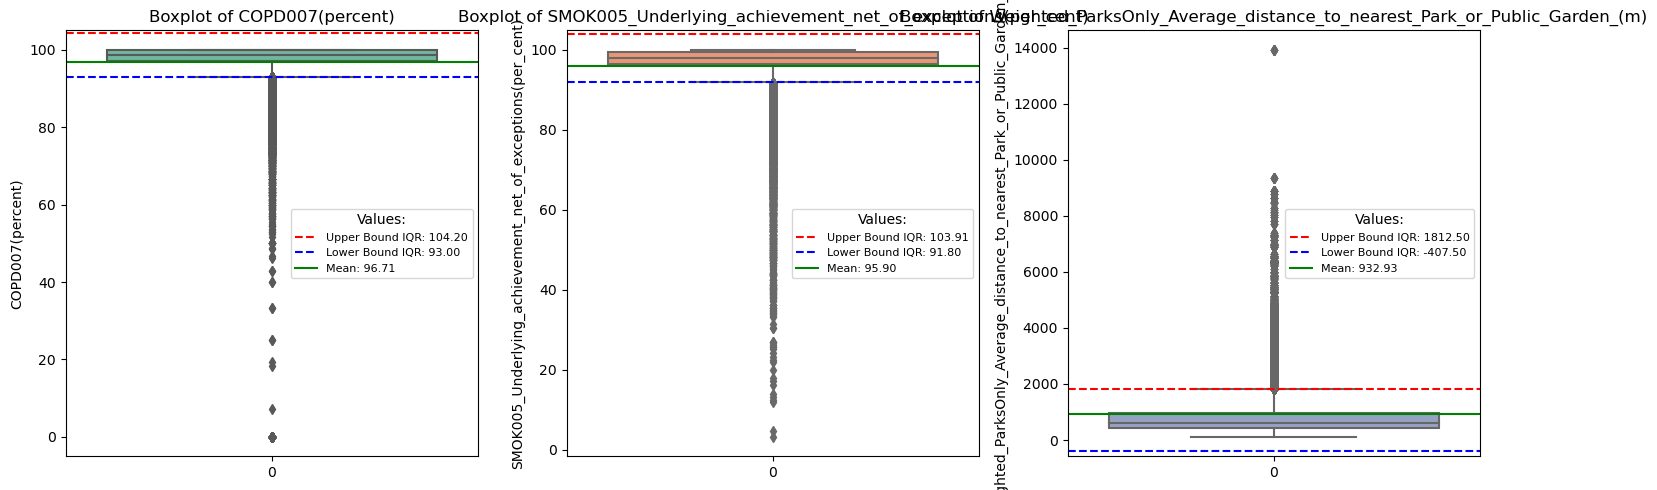

In [130]:
# דוגמה לשימוש:
threshold = 1.5  # ערך הסף
method='IQR'
plot_boxplots(df_after_drop,method, threshold=1.5)

### היסטוגרמה

In [148]:
def plot_histograms_std_and_regular(df, method, threshold, name, num_plots=3, figsize=(15, 10), color_palette='Set2'):
    outliers_df = make_stat_and_detect_outliers(df, threshold)
    
    if method == 'IQR':
        outliers_sorted = outliers_df.sort_values(by='Percent of Outliers IQR', ascending=False)
    elif method == 'stdev':
        outliers_sorted = outliers_df.sort_values(by='Percent of Outliers STDEV', ascending=False)
    else:
        raise ValueError("שיטה לא נתמכת. בחר 'IQR' או 'stdev'.")
    
    top_columns = outliers_sorted.head(num_plots)['Column Name']
    
    fig, axes = plt.subplots(nrows=2, ncols=num_plots, figsize=figsize)
    
    if isinstance(color_palette, str):
        color_palette = sns.color_palette(color_palette)
        
    for i, column in enumerate(top_columns):
        mean = df[column].mean()
        std = df[column].std()
        data_in_std = (df[column] - mean) / std
        
        # היסטוגרמה רגילה
        sns.histplot(df[column], kde=True, color=color_palette[i], ax=axes[0, i])
        axes[0, i].set_xlabel(get_display('רגילה'))
        axes[0, i].set_ylabel(get_display('תדירות'))
        axes[0, i].grid(True)
        
        upper_bound = outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Upper Bound IQR'].values[0]
        lower_bound = outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Lower Bound IQR'].values[0]
        
        # הוספת מקרא לגרף הראשון באמצע למעלה
        axes[0, i].axvline(upper_bound, linestyle='--', color='red', label=get_display(f'גבול עליון IQR: {upper_bound:.2f}'))
        axes[0, i].axvline(lower_bound, linestyle='--', color='blue', label=get_display(f'גבול תחתון IQR: {lower_bound:.2f}'))
        axes[0, i].axvline(mean, linestyle='-', color='green', label=get_display(f'ממוצע: {mean:.2f}'))
        axes[0, i].legend(loc='upper center')
        
        # התאמת גבולות של ציר Y
        y_max = 2600
        axes[0, i].set_ylim(0, y_max)
        axes[0, i].set_yticks(np.arange(0, y_max + 1, y_max / 5))
        
        # היסטוגרמה של סטיות תקן
        sns.histplot(data_in_std, kde=True, color=color_palette[i], ax=axes[1, i])
        axes[1, i].set_xlabel(get_display('סטיות תקן'))
        axes[1, i].set_ylabel(get_display('תדירות'))
        axes[1, i].set_xlim(-4, 4)
        axes[1, i].set_xticks(range(-4, 5))
        axes[1, i].grid(True)
        
        upper_bound_std = (outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Upper Bound IQR'].values[0] - mean) / std
        lower_bound_std = (outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Lower Bound IQR'].values[0] - mean) / std
        
        axes[1, i].axvline(upper_bound_std, linestyle='--', color='red', label=get_display(f'גבול עליון IQR: {upper_bound_std:.2f}'))
        axes[1, i].axvline(lower_bound_std, linestyle='--', color='blue', label=get_display(f'גבול תחתון IQR: {lower_bound_std:.2f}'))
        axes[1, i].axvline(0, linestyle='-')
        axes[1, i].legend(loc='upper left')
        
        # התאמת גבולות של ציר Y
        axes[1, i].set_ylim(0, y_max)
        axes[1, i].set_yticks(np.arange(0, y_max + 1, y_max / 5))
        
        # הוספת טקסט לגרפים
        axes[0, i].text(0.5, 1.1, name[i], horizontalalignment='center', verticalalignment='center', transform=axes[0, i].transAxes, fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()

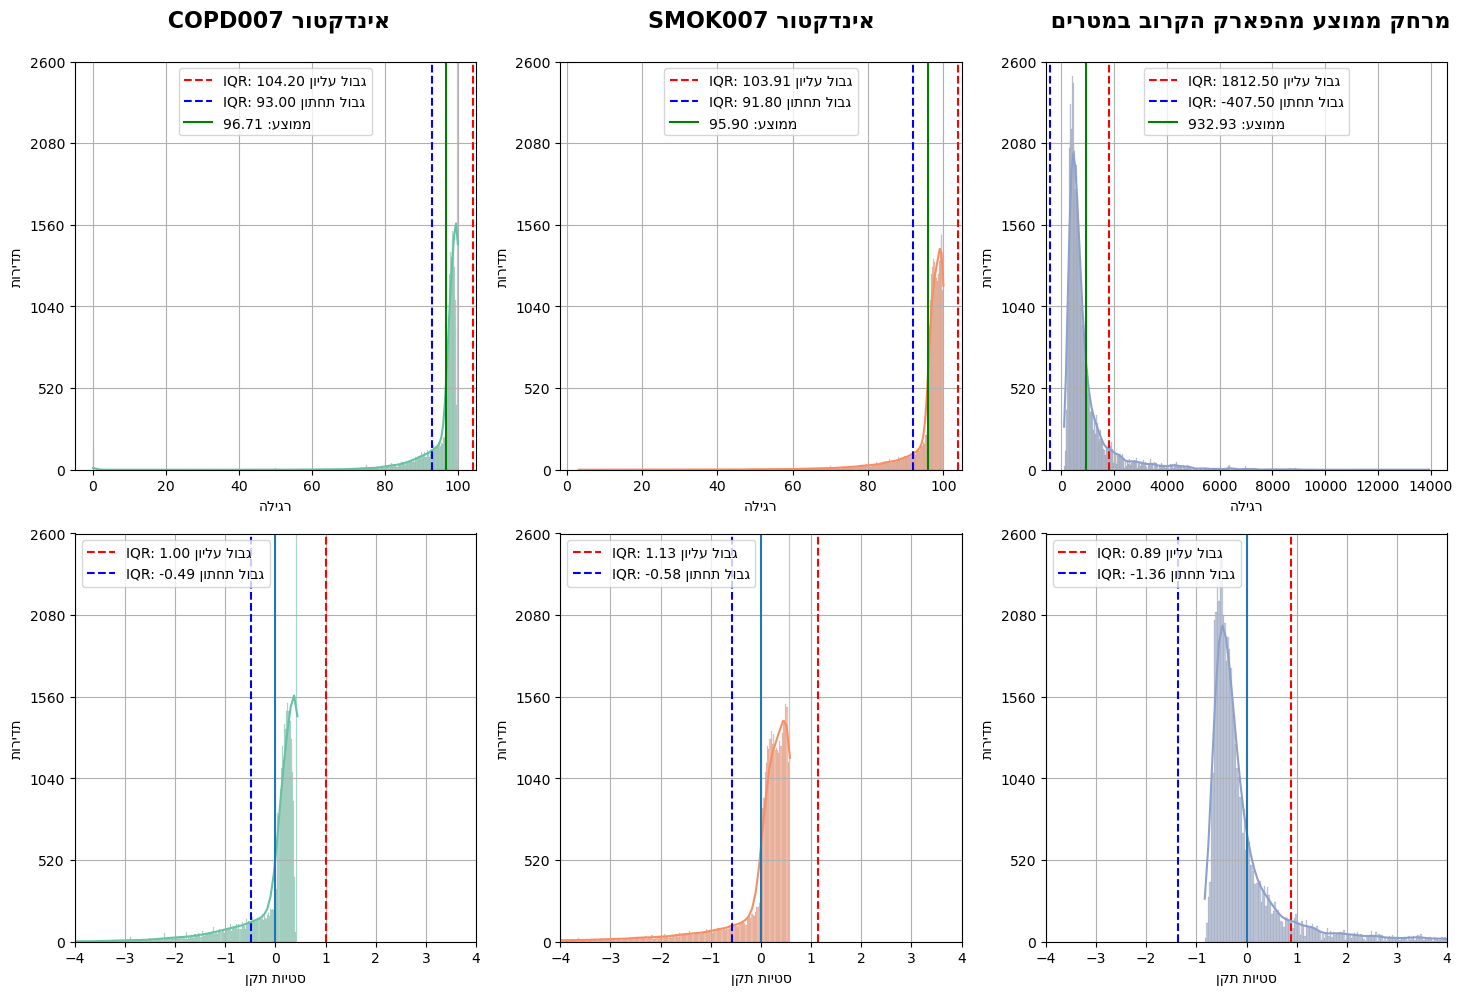

In [150]:
name = [get_display(' COPD007 אינדקטור'),
    get_display('SMOK007 אינדקטור'),
    get_display('מרחק ממוצע מהפארק הקרוב במטרים ')
    ]
plot_histograms_std_and_regular(df_after_drop, method, threshold ,name)

## היסטוגרמות ידניות

In [36]:
# 3 העמודות המובילות
column=outliers_sorted_iqr.iloc[0, 0]
column2=outliers_sorted_iqr.iloc[1, 0]
column3=outliers_sorted_iqr.iloc[2, 0]

columnarr = column1,column2,column3
columnarr

('COPD007(percent)',
 'SMOK005_Underlying_achievement_net_of_exceptions(per_cent)',
 'Weighted_ParksOnly_Average_distance_to_nearest_Park_or_Public_Garden_(m)')

In [32]:
df = df_after_drop



### גרף מס 1

In [28]:
column=outliers_sorted_iqr.iloc[0, 0]
name1 =  get_display('תדירות AST')

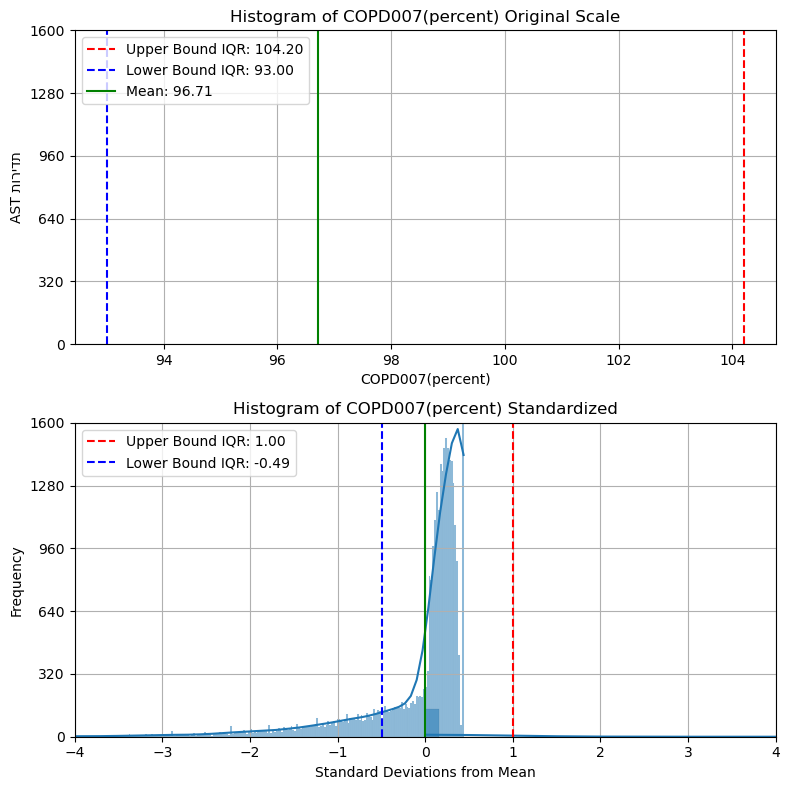

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# יצירת צירים עבור הגרפים
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

# בחירת צבע
color_palette = sns.color_palette()
color = color_palette[0]

# חישוב ממוצע וסטיית תקן
mean = df[column].mean()
std = df[column].std()
data_in_std = (df[column] - mean) / std

# היסטוגרמה רגילה
sns.histplot(df[column], kde=True, color=color, ax=axes[0])
axes[0].set_title(f'Histogram of {column} Original Scale')
axes[0].set_xlabel(column)
axes[0].set_ylabel(name1)
axes[0].grid(True)

# חישוב והוספת קווים אנכיים לגבולות ה-IQR במקור
upper_bound = outliers_sorted_iqr.loc[outliers_sorted_iqr['Column Name'] == column, 'Upper Bound IQR'].iloc[0]
lower_bound = outliers_sorted_iqr.loc[outliers_sorted_iqr['Column Name'] == column, 'Lower Bound IQR'].iloc[0]

axes[0].axvline(upper_bound, linestyle='--', color='red', label=f'Upper Bound IQR: {upper_bound:.2f}')
axes[0].axvline(lower_bound, linestyle='--', color='blue', label=f'Lower Bound IQR: {lower_bound:.2f}')
axes[0].axvline(mean, linestyle='-', color='green', label=f'Mean: {mean:.2f}')

# התאמת גבולות של ציר Y
y_max = 1600
axes[0].set_ylim(0, y_max)
axes[0].set_yticks(np.arange(0, y_max + 1, y_max / 5))

# הוספת מקרא לגרף הראשון
axes[0].legend(loc='upper left')


# היסטוגרמה של סטיות תקן
sns.histplot(data_in_std, kde=True, color=color, ax=axes[1])
axes[1].set_title(f'Histogram of {column} Standardized')
axes[1].set_xlabel('Standard Deviations from Mean')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(-4, 4)
axes[1].set_xticks(range(-4, 5))
axes[1].grid(True)

# חישוב גבולות ה-IQR בסטיות תקן
upper_bound_std = (outliers_sorted_iqr.loc[outliers_sorted_iqr['Column Name'] == column, 'Upper Bound IQR'].iloc[0] - mean) / std
lower_bound_std = (outliers_sorted_iqr.loc[outliers_sorted_iqr['Column Name'] == column, 'Lower Bound IQR'].iloc[0] - mean) / std

# הוספת קווים אנכיים לגבולות ה-IQR ולממוצע
axes[1].axvline(upper_bound_std, linestyle='--', color='red', label=f'Upper Bound IQR: {upper_bound_std:.2f}')
axes[1].axvline(lower_bound_std, linestyle='--', color='blue', label=f'Lower Bound IQR: {lower_bound_std:.2f}')
axes[1].axvline(0, linestyle='-', color='green')

# התאמת גבולות של ציר Y
axes[1].set_ylim(0, y_max)
axes[1].set_yticks(np.arange(0, y_max + 1, y_max / 5))

# הוספת מקרא לגרף השני
axes[1].legend(loc='upper left')

# התאמת פריסת הגרפים והצגת התוצאה
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histograms_std_and_regular(df, method, threshold,name, num_plots=3, figsize=(15, 10), color_palette='Set2'):
    outliers_df = make_stat_and_detect_outliers(df, threshold)
    
    if method == 'IQR':
        outliers_sorted = outliers_df.sort_values(by='Percent of Outliers IQR', ascending=False)
    elif method == 'stdev':
        outliers_sorted = outliers_df.sort_values(by='Percent of Outliers STDEV', ascending=False)
    else:
        raise ValueError("שיטה לא נתמכת. בחר 'IQR' או 'stdev'.")
    
    top_columns = outliers_sorted.head(num_plots)['Column Name']
    
    fig, axes = plt.subplots(nrows=2, ncols=num_plots, figsize=figsize)
    
    if isinstance(color_palette, str):
        color_palette = sns.color_palette(color_palette)
        

    
    for i, column in enumerate(top_columns):
        mean = df[column].mean()
        std = df[column].std()
        data_in_std = (df[column] - mean) / std
        
        
        
         # היסטוגרמה רגילה
        sns.histplot(df[column], kde=True, color=color_palette[i])
        axes[0, i].set_ylabel(get_display(' רגילה'))
        axes[0, i].set_ylabel(get_display(' תדירות'))
        axes[0, i].grid(True)
        
        upper_bound = outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Upper Bound IQR'].values[0]
        lower_bound = outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Lower Bound IQR'].values[0]
        
        axes[0, i].axvline(upper_bound, linestyle='--', color='red')
        axes[0, i].axvline(lower_bound, linestyle='--', color='blue')
        axes[0, i].axvline(mean, linestyle='-', color='green')
        
        # התאמת גבולות של ציר Y
        y_max = 2600
        axes[0, i].set_ylim(0, y_max)
        axes[0, i].set_yticks(np.arange(0, y_max + 1, y_max / 5))
        
        # היסטוגרמה של סטיות תקן
        sns.histplot(data_in_std, kde=True, color=color_palette[i], ax=axes[1, i])
        #axes[1, i].set_title(f'Histogram of {column}\n(Standardized)')
        axes[1, i].set_xlabel(get_display(' סטיות תקן'))
        axes[1, i].set_ylabel(get_display(' תדירות'))
        axes[1, i].set_xlim(-4, 4)
        axes[1, i].set_xticks(range(-4, 5))
        axes[1, i].grid(True)
        
        upper_bound_std = (outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Upper Bound IQR'].values[0] - mean) / std
        lower_bound_std = (outliers_sorted.loc[outliers_sorted['Column Name'] == column, 'Lower Bound IQR'].values[0] - mean) / std
        
        axes[1, i].axvline(upper_bound_std, linestyle='--', color='red')
        axes[1, i].axvline(lower_bound_std, linestyle='--', color='blue')
        axes[1, i].axvline(0, linestyle='-', color='green')
        
        # התאמת גבולות של ציר Y
        y_max = 2600
        axes[1, i].set_ylim(0, y_max)
        axes[1, i].set_yticks(np.arange(0, y_max + 1, y_max / 5))
        
               # הוספת טקסט לגרפים
        axes[0, i].text(0.5, 1.1, name[i] , horizontalalignment='center', verticalalignment='center', transform=axes[0, i].transAxes, fontsize=16, fontweight='bold')


    plt.tight_layout()
    plt.show()


